# Sattelite Image Classification

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
import seaborn as sns

from tensorflow import keras
from keras import Input, Model, Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Flatten, InputLayer, Reshape, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [2]:
# Dict of labels
categories = {
                'cloudy': 0,
                'desert': 1,
                'green_area': 2,
                'water': 3
            }

## Load images

In [3]:
def load_images(images_folder, img_size = (128,128), scale=False):

    # Store paths to images
    image_path = []
    for dirname, _, filenames in os.walk(images_folder):
        for filename in filenames:
            image_path.append(os.path.join(dirname, filename))

    print("There are {} images in {}".format(len(image_path), images_folder))

    # Load images and associated labels
    images = []
    labels = []

    for path in tqdm.tqdm(image_path):

        img = cv2.imread(path)
        img = cv2.resize(img, img_size) # Resize the images

        img = np.array(img)

        images.append(img)
        labels.append(categories[path.split('/')[-2]]) # last folder before the image name is the category

    images = np.array(images)
    images = images.astype(np.int64)

    if scale:
        images = images/255 # scale

    return image_path, images, np.asarray(labels)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("Path to dataset files:", path)

100%|██████████| 21.8M/21.8M [00:02<00:00, 10.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1


In [5]:
img_size = (128,128)
#images_folder = os.path.join('/', 'kaggle', 'input', 'satellite-image-classification', 'data')
images_folder =os.path.join(path)
image_path, images, labels = load_images(images_folder, img_size=img_size)

# Resize
# images = np.array(images).reshape(-1,128,128,1)
images.shape

There are 5631 images in /root/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1


100%|██████████| 5631/5631 [00:01<00:00, 2865.80it/s]


(5631, 128, 128, 3)

Let's take a look at the categories (target values) :

In [6]:
set(labels)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3)}

## Visualizing

Plot some of the images from the train set

In [7]:
labels

array([0, 0, 0, ..., 3, 3, 3])

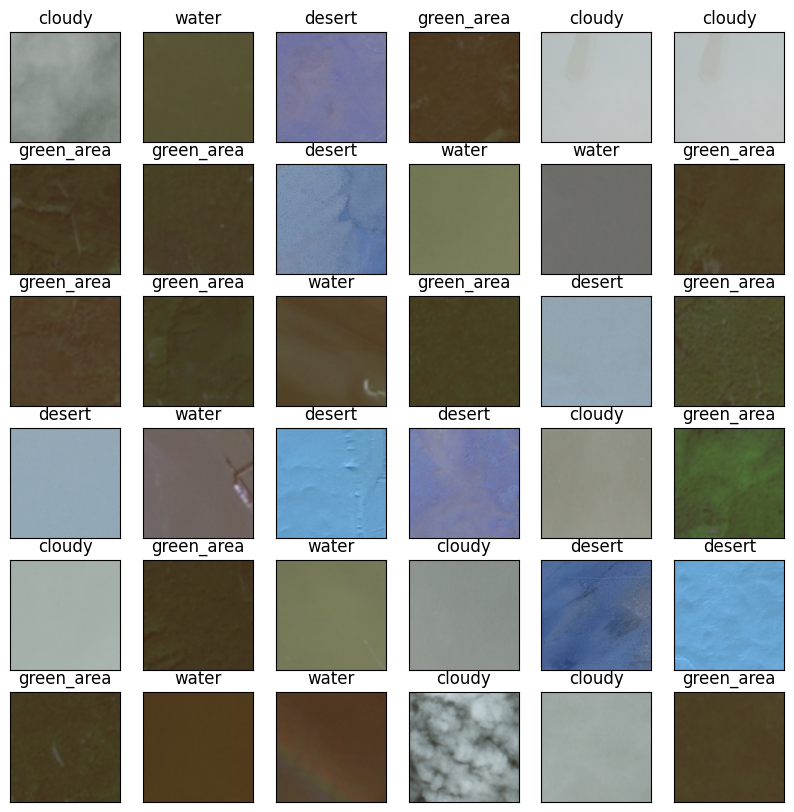

In [8]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(len(image_path),36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(images[image_ind]), cmap=plt.cm.binary)

    label = list(categories.keys())[list(categories.values()).index(labels[image_ind])]
    plt.title(label)

In [9]:
((images[1600].shape))


(128, 128, 3)

In [10]:
images

array([[[[ 96, 116, 117],
         [ 88, 111, 114],
         [ 83, 107, 111],
         ...,
         [169, 185, 187],
         [168, 184, 186],
         [165, 184, 186]],

        [[ 96, 118, 120],
         [ 91, 114, 116],
         [ 88, 109, 110],
         ...,
         [170, 187, 189],
         [169, 186, 188],
         [168, 186, 188]],

        [[ 96, 118, 122],
         [ 92, 113, 116],
         [ 89, 107, 108],
         ...,
         [169, 188, 190],
         [168, 187, 189],
         [168, 186, 188]],

        ...,

        [[129, 152, 156],
         [128, 153, 155],
         [127, 153, 154],
         ...,
         [190, 206, 209],
         [190, 206, 209],
         [190, 206, 209]],

        [[133, 154, 156],
         [132, 153, 155],
         [130, 152, 153],
         ...,
         [189, 205, 208],
         [189, 205, 208],
         [189, 205, 208]],

        [[135, 155, 157],
         [133, 153, 154],
         [130, 151, 152],
         ...,
         [188, 204, 207],
        

How are the categories distributed?

In [11]:
labels_df = pd.DataFrame(labels)
labels_df.value_counts()

0
0    1500
2    1500
3    1500
1    1131
Name: count, dtype: int64

In [12]:
labels_df

0
0     0
1     0
2     0
3     0
4     0
...  ..
5626  3
5627  3
5628  3
5629  3
5630  3

[5631 rows x 1 columns]

## Model building

In [13]:
len(categories)

4

In [14]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

def build_cnn_model():
    cnn_model=tf.keras.Sequential([
      Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=images.shape[1:]),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),


      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(0.4),

      Flatten(),

      Dense(units=len(categories),activation='softmax')
    ])

    return cnn_model

model = build_cnn_model()
# Initialize the model by passing some data through
model.predict(images[[0]])
# Print the summary of the layers in the model.
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 128)      │           51

 Total params: 1,719,300 (6.56 MB)

 Trainable params: 1,717,956 (6.55 MB)

 Non-trainable params: 1,344 (5.25 KB)

None


## Plot the model

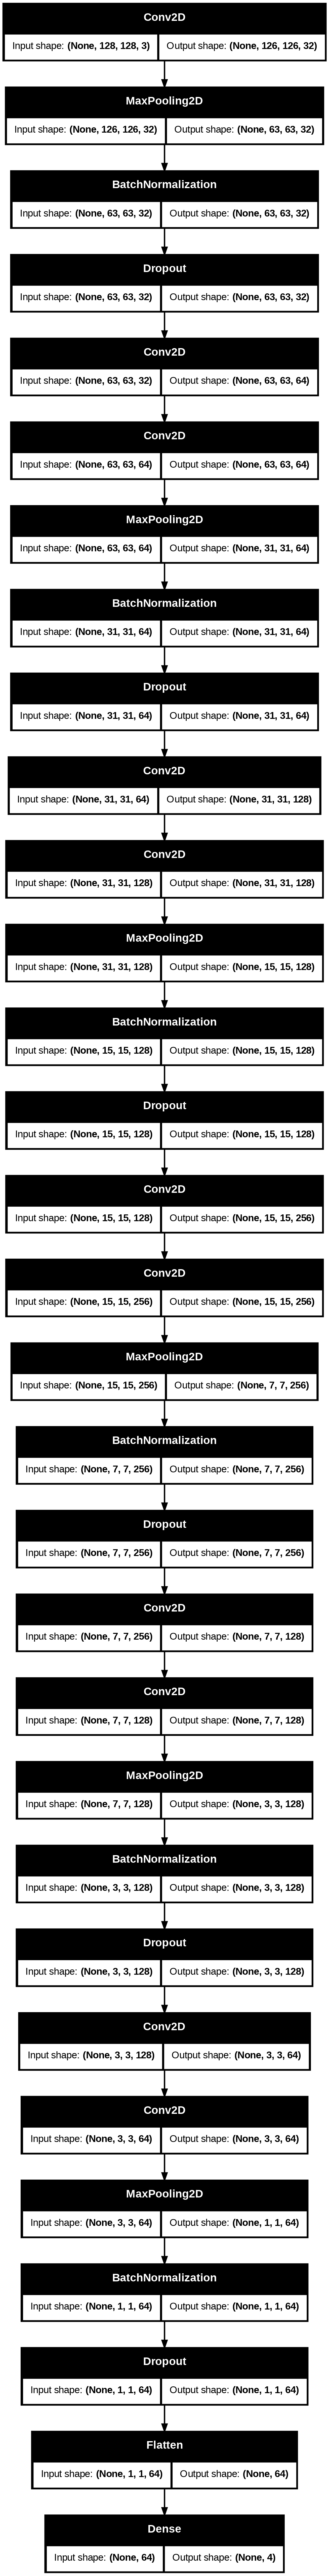

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Convert labels to categorical

In [16]:
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)
labels[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

## Compile model and proceed to training

In [18]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

### Some callbacks

We add some callbacks to save the weights of the model and for early stopping.

In [19]:
checkpoint_filepath = '/kaggle/working/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq=500)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.001,
    mode='max',
    restore_best_weights=True
)

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor = "val_accuracy",factor = 0.3, patience = 3,
                            min_delta = 0.001,mode = 'auto',verbose=1)

In [22]:
# images[0][0]

In [23]:
print(images.shape)
print(labels.shape)

(5631, 128, 128, 3)
(5631, 4)


## Split the data

In [24]:
from sklearn.model_selection import train_test_split
# Train, validation and test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.10, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

In [25]:
y_train

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [26]:
print("*-*-*-*-*-*")
print("Train")
print(X_train.shape)
print(y_train.shape)

print("*-*-*-*-*-*")
print("Validation")
print(X_val.shape)
print(y_val.shape)

print("*-*-*-*-*-*")
print("Test")
print(X_test.shape)
print(y_test.shape)

*-*-*-*-*-*
Train
(4053, 128, 128, 3)
(4053, 4)
*-*-*-*-*-*
Validation
(1014, 128, 128, 3)
(1014, 4)
*-*-*-*-*-*
Test
(564, 128, 128, 3)
(564, 4)


## Model training

In [27]:
y_train[0]

array([0., 1., 0., 0.])

In [28]:
y_val[0]

array([0., 1., 0., 0.])

In [29]:
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks=[model_checkpoint_callback, early_stopping, reducelr])

Epoch 1/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.6929 - loss: 0.5279 - val_accuracy: 0.5937 - val_loss: 1.1868 - learning_rate: 0.0010
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8635 - loss: 0.2561 - val_accuracy: 0.6292 - val_loss: 0.8688 - learning_rate: 0.0010
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8607 - loss: 0.2178 - val_accuracy: 0.6134 - val_loss: 1.6103 - learning_rate: 0.0010
Epoch 4/1000
124/127 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8557 - loss: 0.2186

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8559 - loss: 0.2182 - val_accuracy: 0.7988 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 5/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8692 - loss: 0.1887 - val_accuracy: 0.8688 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 6/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8713 - loss: 0.1825 - val_accuracy: 0.8531 - val_loss: 0.3818 - learning_rate: 0.0010
Epoch 7/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8910 - loss: 0.1693 - val_accuracy: 0.8077 - val_loss: 0.2117 - learning_rate: 0.0010
Epoch 8/1000
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8773 - loss: 0.1670
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8773 - loss: 0.1670 - val_accuracy: 0.8531 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 9/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8995 - loss: 0.13

### Plot the performances

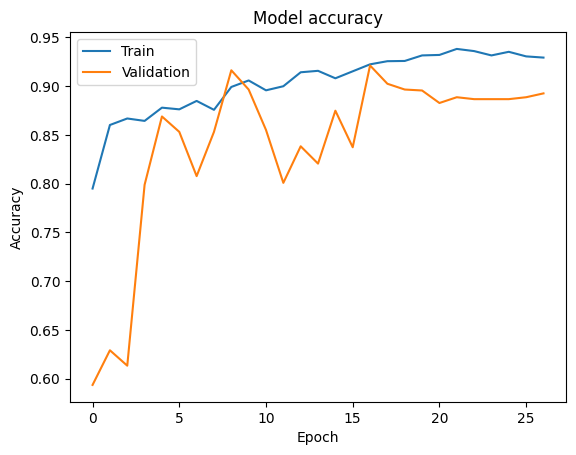

In [30]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

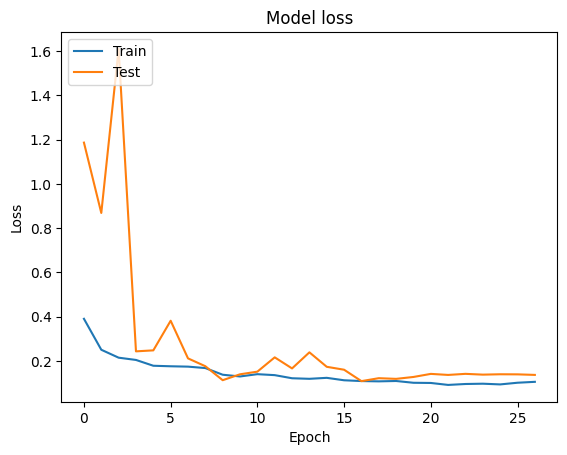

In [31]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

## Predict on new data

In [32]:
def predict_class(img):
    # Resize
    img = img.reshape(1,128,128,3)
    # Predict
    predictions = model.predict(img)
    true_prediction = [tf.argmax(pred) for pred in predictions]
    true_prediction = np.array(true_prediction)

    # Return label corresponding to predicted index
    return list(categories.keys())[list(categories.values()).index(true_prediction)]


In [33]:
X_test[0].shape

(128, 128, 3)

In [34]:
predict_class(X_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


'water'

In [35]:
# Predict on test set
y_pred = model.predict(X_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [36]:
y_pred.shape

(564, 4)

In [37]:
# From categorical outputs to discrete values
y_pred_ = [np.argmax(y) for y in y_pred]
y_test_ = [np.argmax(y) for y in y_test]

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       150
           1       0.96      0.98      0.97       110
           2       0.81      1.00      0.90       153
           3       1.00      0.76      0.86       151

    accuracy                           0.93       564
   macro avg       0.94      0.93      0.93       564
weighted avg       0.94      0.93      0.92       564



## Confusion matrix

(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

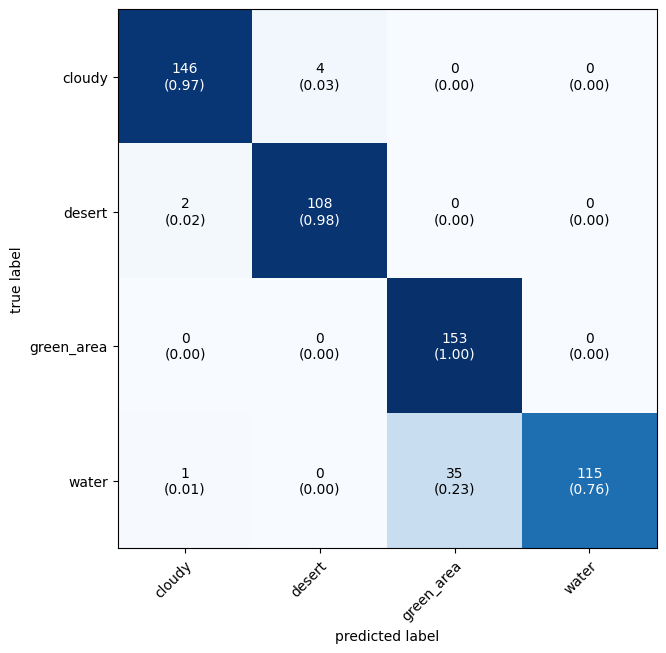

In [39]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test_,y_pred_)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

There is a lot of confusion from the model between the "water" and "green_area" images.

### Plot some images and predicted labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

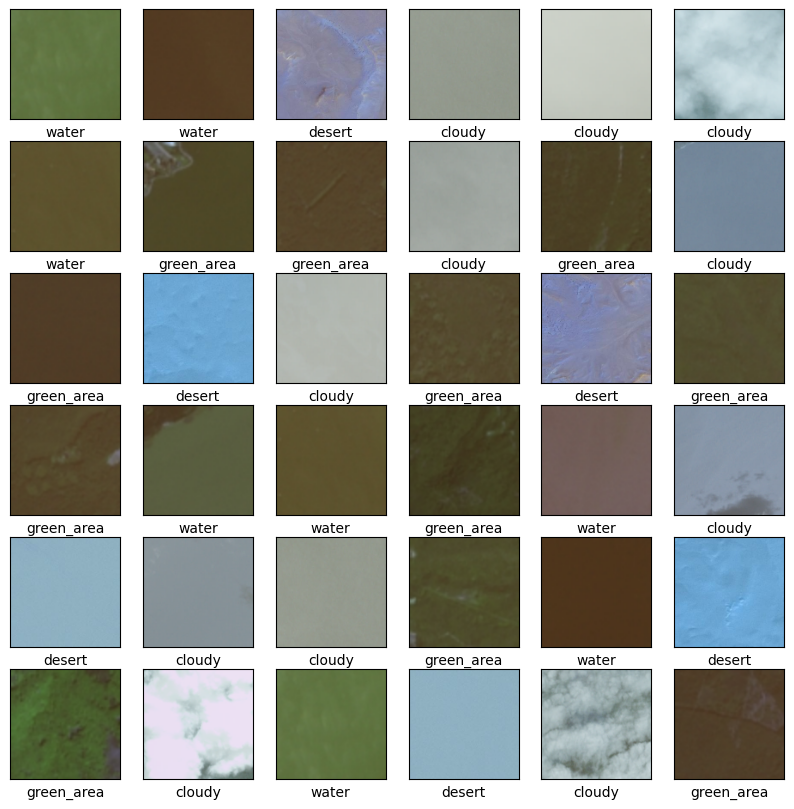

In [40]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(X_test.shape[0],36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_test[image_ind]), cmap=plt.cm.binary)

    # Predict and get label
    label = predict_class(X_test[image_ind])
    plt.xlabel(label)

### Save the model

In [41]:
model.save("sattelite_image_classifier.h5")

# CNN+ VIT

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    Dropout,
    MaxPooling2D,
    BatchNormalization,
    LayerNormalization,
    MultiHeadAttention,
    Embedding,
    Input,
    Layer
)
from tensorflow.keras.models import Model

# Assume 'images' and 'categories' are defined as in your original context
# For example:
# images = np.random.rand(100, 128, 128, 3)
# categories = ['cat', 'dog', 'bird']

def build_hybrid_cnn_vit_model(input_shape, num_classes, projection_dim=128, num_heads=4, transformer_layers=4, mlp_units=[256, 128]):
    """
    Builds a hybrid CNN and Vision Transformer model.

    Args:
        input_shape (tuple): The shape of the input images.
        num_classes (int): The number of output classes.
        projection_dim (int): The dimensionality of the patch embeddings.
        num_heads (int): The number of attention heads in the Transformer.
        transformer_layers (int): The number of Transformer encoder blocks.
        mlp_units (list): The number of units in the MLP head.

    Returns:
        tf.keras.Model: The compiled hybrid model.
    """
    inputs = Input(shape=input_shape)

    # --- CNN Backbone ---
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # --- Vision Transformer ---
        # Get static shape safely
    h = x.shape[1]
    w = x.shape[2]
    c = x.shape[3]

# Convert CNN feature map -> sequence of patches
    patches = tf.keras.layers.Reshape((h * w, c))(x)
    # Patch projection
    patch_embedding = Dense(projection_dim)(patches)

# Positional embedding
    #position_embedding = PositionEmbedding(h * w, projection_dim)(patch_embedding)



    class PositionEmbedding(Layer):
        def __init__(self, sequence_length, output_dim, **kwargs):
            super().__init__(**kwargs)
            self.position_embeddings = Embedding(
                input_dim=sequence_length, output_dim=output_dim
            )
            self.sequence_length = sequence_length
            self.output_dim = output_dim

        def call(self, inputs):
            length = tf.shape(inputs)[1]
            positions = tf.range(start=0, limit=length, delta=1)
            embedded_positions = self.position_embeddings(positions)
            return inputs + embedded_positions

        def get_config(self):
            config = super().get_config()
            config.update({
                "sequence_length": self.sequence_length,
                "output_dim": self.output_dim,
            })
            return config

    position_embedding = PositionEmbedding(h * w, projection_dim)(patch_embedding)

    # Transformer Encoder
    encoded_patches = Dropout(0.4)(position_embedding)
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = Dense(units=projection_dim * 2, activation=tf.nn.gelu)(x3)
        x3 = Dropout(0.1)(x3)
        x3 = Dense(units=projection_dim, activation=tf.nn.gelu)(x3)
        x3 = Dropout(0.1)(x3)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # --- Classification Head ---
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    # Create MLP.
    for units in mlp_units:
        representation = Dense(units, activation="relu")(representation)
        representation = Dropout(0.5)(representation)
    # Classify outputs.
    logits = Dense(num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits)
    return model

# # Assuming 'images' and 'categories' are defined
# # Example placeholder shapes and values
# # Get the input shape from your data
input_shape = images.shape[1:]
num_classes = len(categories)

# # Build the model
hybrid_model = build_hybrid_cnn_vit_model(input_shape=input_shape, num_classes=num_classes)

# # Initialize the model by passing some data through it
hybrid_model.predict(images[[0]])

# # Print the summary of the layers in the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


array([[0.29609236, 0.1912856 , 0.01024367, 0.5023784 ]], dtype=float32)

In [43]:
images.shape[1:]

(128, 128, 3)

In [44]:
len(categories)

4

In [45]:
print(hybrid_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 126, 126,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 63, 63,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        128 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 63, 63,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 63, 63,    │     18,496 │ dropout_6[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 63, 63,    │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 31, 31,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        256 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 31, 31,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 31, 31,    │     73,856 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 31, 31,    │    147,584 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 15, 15,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 15, 15,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 225, 128)  │          0 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 225, 128)  │     16,512 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,051,652 (34.53 MB)

 Trainable params: 9,051,204 (34.53 MB)

 Non-trainable params: 448 (1.75 KB)

None


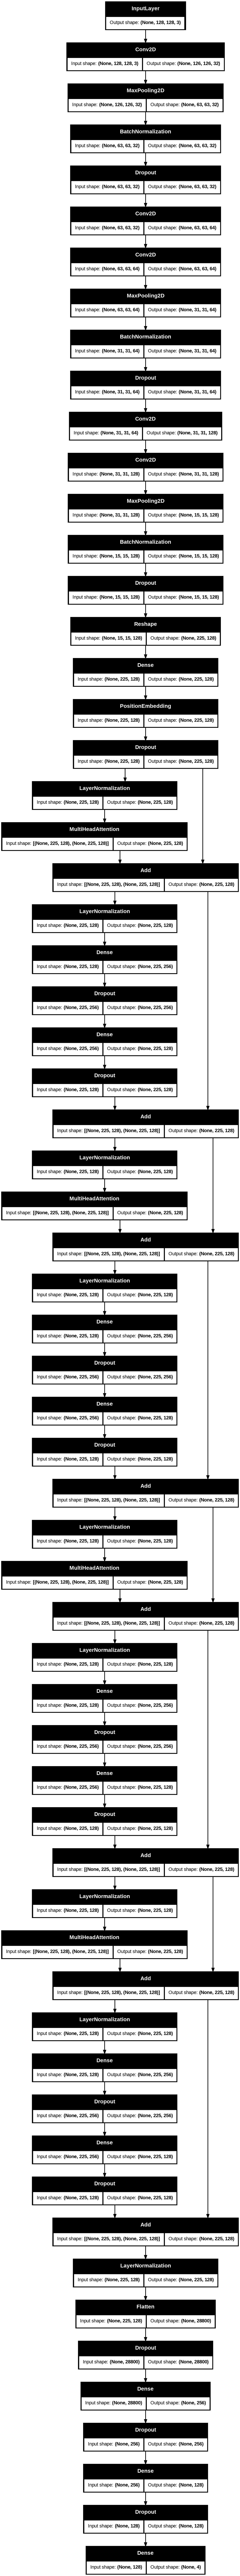

In [46]:
tf.keras.utils.plot_model(hybrid_model, show_shapes=True)

In [47]:
hybrid_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [48]:
checkpoint_filepath = '/kaggle/working/checkpoint.weights.h5'
model_checkpoint_callbacck = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq=500)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.001,
    mode='max',
    restore_best_weights=True
)

In [50]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor = "val_accuracy",factor = 0.3, patience = 3,
                            min_delta = 0.001,mode = 'auto',verbose=1)

In [51]:
history = hybrid_model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks=[model_checkpoint_callback, early_stopping, reducelr])

Epoch 1/1000
 70/127 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5762 - loss: 0.8569

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


127/127 ━━━━━━━━━━━━━━━━━━━━ 124s 529ms/step - accuracy: 0.6235 - loss: 0.7445 - val_accuracy: 0.5444 - val_loss: 0.6478 - learning_rate: 0.0010
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7157 - loss: 0.3943 - val_accuracy: 0.8442 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6870 - loss: 0.4187 - val_accuracy: 0.7426 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 4/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6743 - loss: 0.3819 - val_accuracy: 0.5533 - val_loss: 0.7062 - learning_rate: 0.0010
Epoch 5/1000
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7482 - loss: 0.3466
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7478 - loss: 0.3468 - val_accuracy: 0.7544 - val_loss: 0.4365 - learning_rate: 0.0010
Epoch 6/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7622 - loss: 0

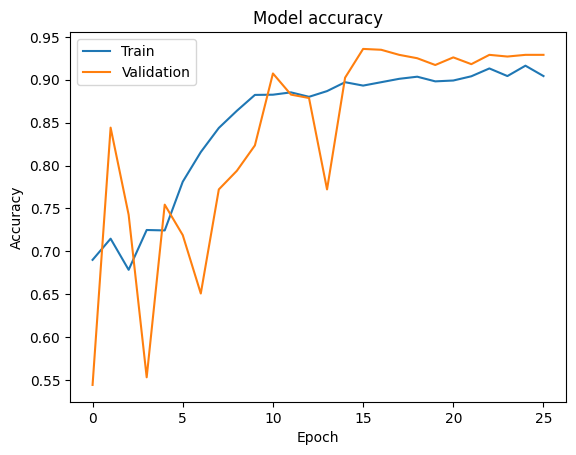

In [52]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

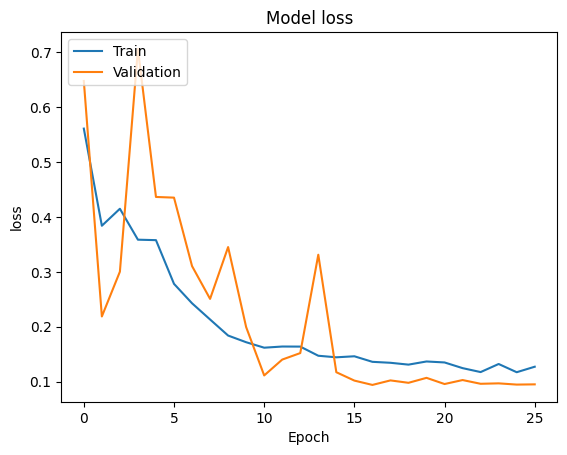

In [53]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 791ms/step
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       150
           1       0.99      0.93      0.96       110
           2       0.87      0.99      0.93       153
           3       0.99      0.83      0.90       151

    accuracy                           0.94       564
   macro avg       0.95      0.94      0.94       564
weighted avg       0.94      0.94      0.94       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

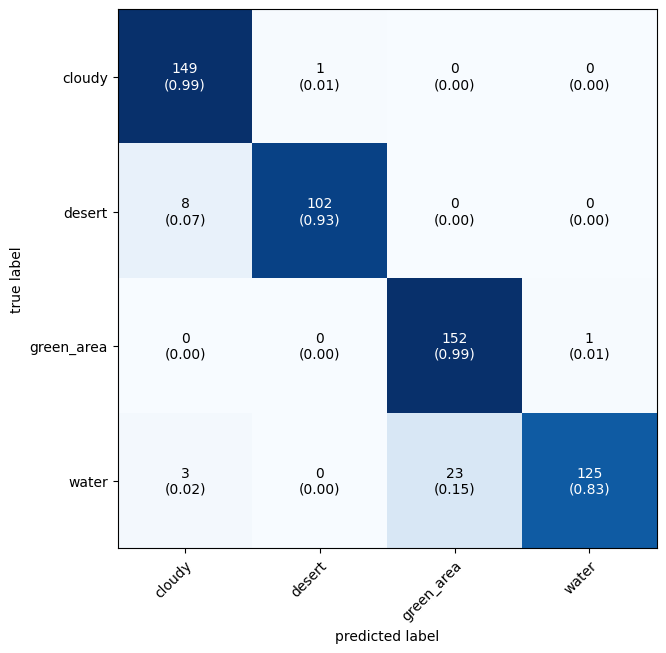

In [54]:
# Predict on test set
y_pred = hybrid_model.predict(X_test)
y_pred_ = [np.argmax(y) for y in y_pred]


from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))


from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test_,y_pred_)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

# GAN+CNN

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# --- PREPROCESSING ---

# 1. Isolate Class 1 (Desert) images
# Assuming 'labels' is the integer array (0, 1, 2, 3) shown in your first screenshot
# and 'images' is your (5631, 128, 128, 3) array.

# We need to find indices where label is 1
# Note: If you have already one-hot encoded 'labels', run:

# Otherwise, if labels is still integers:
indices_class_1 = np.where(labels == 1)[0]

indices_class_1 = np.argmax(labels, axis=1) == 1
X_train_gan = images[indices_class_1]

print(f"Images for GAN training (Class 1): {X_train_gan.shape}")

# 2. Normalize images to [-1, 1] range
# GANs typically use Tanh activation in the generator, which outputs -1 to 1.
# Assuming your input images are currently 0-255 or 0-1.
if X_train_gan.max() > 1.0:
    X_train_gan = (X_train_gan - 127.5) / 127.5
else:
    X_train_gan = (X_train_gan * 2) - 1

# 3. Create a TensorFlow dataset for efficient batching
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train_gan).shuffle(1131).batch(BATCH_SIZE)

Images for GAN training (Class 1): (1131, 128, 128, 3)


In [56]:
latent_dim = 100

def make_generator_model():
    model = models.Sequential()

    # Start with 8x8 size and upsample 4 times (16->32->64->128)
    # 8 * 8 * 256
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 32x32
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 64x64
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 128x128
    # Output layer uses 'tanh' to match the [-1, 1] preprocessing
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    model = models.Sequential()

    # Input 128x128
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 32x32
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 16x16
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 8x8
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output: Real (positive) or Fake (negative) score

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training Loop Execution
import time

EPOCHS = 100 # Increase this (e.g., 200-500) for better quality results

print("Starting Training...")
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Optional: Save output every 10 epochs to check progress
    if (epoch + 1) % 10 == 0:
        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

Starting Training...
Time for epoch 10 is 0.54 sec
Time for epoch 20 is 0.54 sec
Time for epoch 30 is 0.54 sec
Time for epoch 40 is 0.55 sec
Time for epoch 50 is 0.54 sec
Time for epoch 60 is 0.54 sec
Time for epoch 70 is 0.54 sec
Time for epoch 80 is 0.54 sec
Time for epoch 90 is 0.55 sec
Time for epoch 100 is 0.54 sec


Generating 219 synthetic images for Class 1...


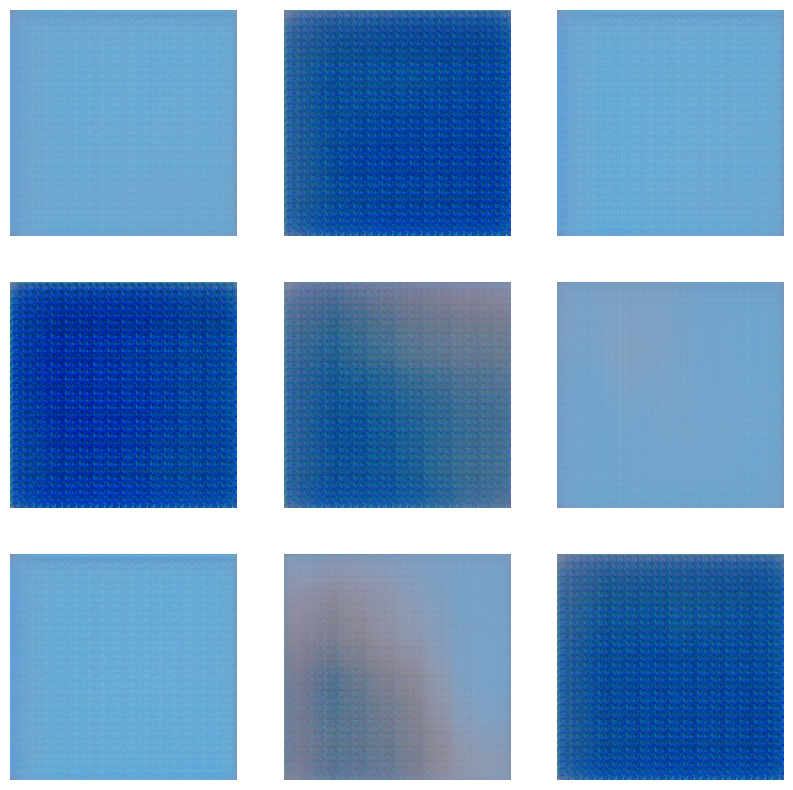

New Training Shape: (4272, 128, 128, 3)
New Label Shape: (4272, 4)


In [58]:
# 1. Calculate needed amount
needed_count = (int(1500*0.9))  - 1131
print(f"Generating {needed_count} synthetic images for Class 1...")

# 2. Generate
noise = tf.random.normal([needed_count, latent_dim])
generated_images = generator(noise, training=False)

# 3. Denormalize: Convert from [-1, 1] back to [0, 1] (or 0-255)
# Assuming your original images were 0-1 floats:
generated_images = (generated_images * 0.5) + 0.5
# 3. Scale range from [0, 1] to [0, 255]
generated_images = generated_images * 255

# 4. Ensure values don't go below 0 or above 255 (safety clip) and convert to Integers
generated_images = np.clip(generated_images, 0, 255).astype('uint8')
#generated_images = generated_images.numpy() # Convert to numpy array

# 4. Create Labels for the new images
new_labels = np.full((needed_count,), 1) # Create array of 1s
# If you need one-hot encoded labels for the new data:
new_labels_encoded = to_categorical(new_labels, num_classes=4)

# 5. Visualize a few generated results
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.show()

#6. Append to original dataset (Conceptually)
X_train_augmented = np.concatenate((X_train, generated_images))
y_train_augmented = np.concatenate((y_train, new_labels_encoded))

from sklearn.utils import shuffle
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=42)

print(f"New Training Shape: {X_train_augmented.shape}")
print(f"New Label Shape: {y_train_augmented.shape}")

In [59]:
y_train_augmented

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [60]:
history = model.fit(X_train_augmented, y_train_augmented,
                    batch_size = 32,
                    epochs = 1000,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks=[model_checkpoint_callback, early_stopping, reducelr])

Epoch 1/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9146 - loss: 0.1179 - val_accuracy: 0.8925 - val_loss: 0.1320 - learning_rate: 7.2900e-07
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9250 - loss: 0.1062 - val_accuracy: 0.8886 - val_loss: 0.1342 - learning_rate: 7.2900e-07
Epoch 3/1000
  1/134 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.9688 - loss: 0.0546

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9238 - loss: 0.1039 - val_accuracy: 0.8846 - val_loss: 0.1374 - learning_rate: 7.2900e-07
Epoch 4/1000
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9129 - loss: 0.1214
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9130 - loss: 0.1213 - val_accuracy: 0.8866 - val_loss: 0.1371 - learning_rate: 7.2900e-07
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9241 - loss: 0.1036 - val_accuracy: 0.8876 - val_loss: 0.1368 - learning_rate: 2.1870e-07
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9182 - loss: 0.1147 - val_accuracy: 0.8876 - val_loss: 0.1344 - learning_rate: 2.1870e-07
Epoch 7/1000
131/134 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9261 - loss: 0.1057
Epoch 7: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.925

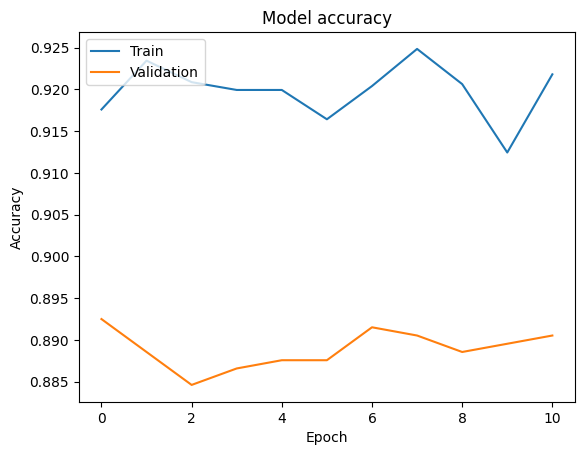

In [61]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

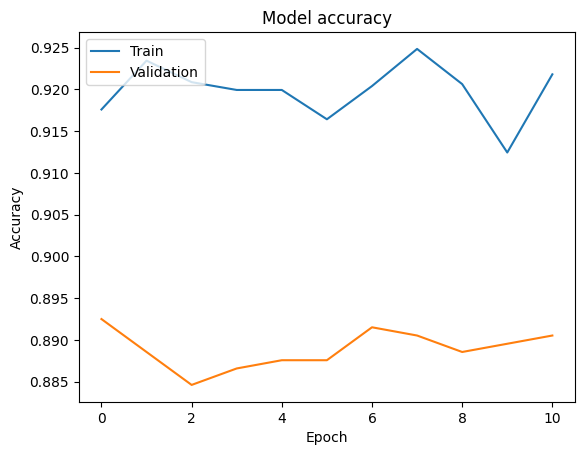

In [62]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       150
           1       0.99      0.93      0.96       110
           2       0.87      0.99      0.93       153
           3       0.99      0.83      0.90       151

    accuracy                           0.94       564
   macro avg       0.95      0.94      0.94       564
weighted avg       0.94      0.94      0.94       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

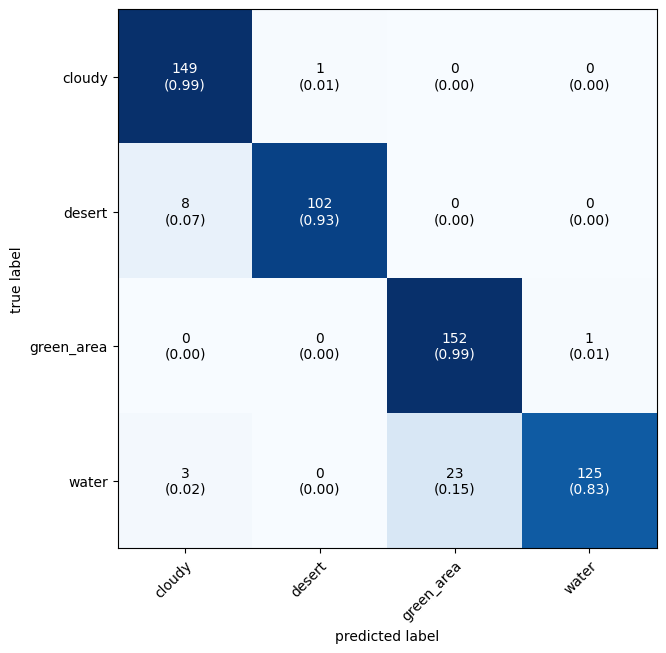

In [63]:
# Predict on test set
y_pred = hybrid_model.predict(X_test)
y_pred_ = [np.argmax(y) for y in y_pred]


from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))


from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test_,y_pred_)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

# Transfer learning with VGG16

In [64]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Model

all_predictions = {}
all_metrics = []

def build_vgg_model(input_shape=(128,128,3)):

    base_model = VGG16(input_shape=input_shape,include_top=False,weights='imagenet')
    base_model.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(0.4)(model)
    model = Dense(128, activation='relu')(model)
    model = Dense(len(categories),activation='softmax')(model)

    model = Model(inputs = base_model.input, outputs = model)

    return model

vgg_model = build_vgg_model()
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [65]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Model

def build_vgg_model(input_shape=(128,128,3)):

    base_model = VGG16(input_shape=input_shape,include_top=False,weights='imagenet')
    base_model.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(0.4)(model)
    model = Dense(128, activation='relu')(model)
    model = Dense(len(categories),activation='softmax')(model)

    model = Model(inputs = base_model.input, outputs = model)

    return model

vgg_model = build_vgg_model()
vgg_model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [66]:
vgg_model.compile(optimizer ="adam", loss = "binary_crossentropy",metrics = ['accuracy'])

In [67]:
history_vgg = vgg_model.fit(X_train, y_train,
                    batch_size = 128,
                    epochs = 1000,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks=[model_checkpoint_callback, early_stopping, reducelr])

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 544ms/step - accuracy: 0.4903 - loss: 0.6614 - val_accuracy: 0.9379 - val_loss: 0.1225 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8910 - loss: 0.1664 - val_accuracy: 0.9398 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9246 - loss: 0.1239 - val_accuracy: 0.9507 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9324 - loss: 0.1117 - val_accuracy: 0.9566 - val_loss: 0.0707 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9411 - loss: 0.0949 - val_accuracy: 0.9556 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9464 - loss: 0.0849 - val_accuracy: 0.9586 - val_loss: 0.0669 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9463 - loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9547 - loss: 0.0706 - val_accuracy: 0.9625 - val_loss: 0.0598 - learning_rate: 0.0010
Epoch 11/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9585 - loss: 0.0664 - val_accuracy: 0.9625 - val_loss: 0.0578 - learning_rate: 0.0010
Epoch 12/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9488 - loss: 0.0715
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9492 - loss: 0.0713 - val_accuracy: 0.9615 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9585 - loss: 0.0643 - val_accuracy: 0.9635 - val_loss: 0.0572 - learning_rate: 3.0000e-04
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9573 - loss: 0.0628 - val_accuracy: 0.9645 - val_loss: 0.0554 - learning_rate: 3.0000e-04
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9583 - loss: 0.06

In [68]:
y_test_ = [np.argmax(y) for y in y_test]
y_pred_vgg = vgg_model.predict(X_test)
y_pred_vgg_ = [np.argmax(y) for y in y_pred_vgg]

from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_vgg_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       150
           1       0.94      1.00      0.97       110
           2       0.99      0.99      0.99       153
           3       0.99      0.98      0.98       151

    accuracy                           0.98       564
   macro avg       0.98      0.98      0.98       564
weighted avg       0.98      0.98      0.98       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

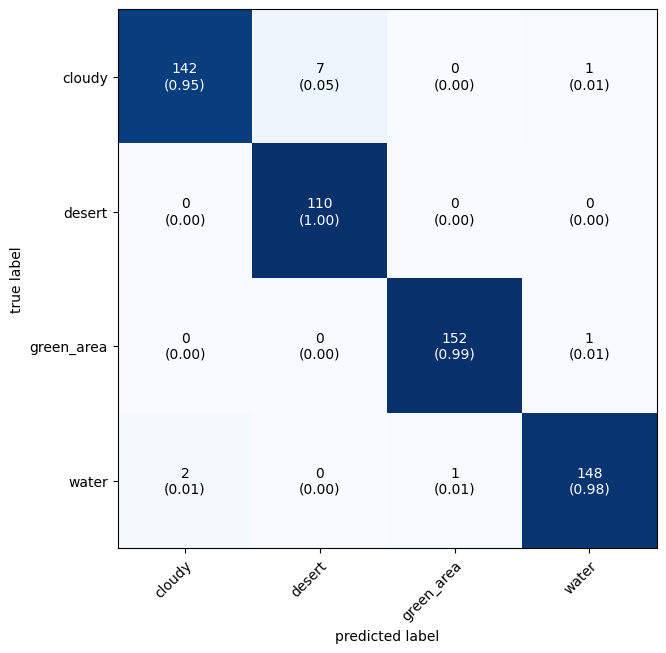

In [69]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm_vgg = confusion_matrix(y_test_,y_pred_vgg_)
plot_confusion_matrix(conf_mat = cm_vgg,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

In [70]:
y_test_ = [np.argmax(y) for y in y_test]
y_pred_vgg = vgg_model.predict(X_test)
y_pred_vgg_ = [np.argmax(y) for y in y_pred_vgg]

from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_vgg_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       150
           1       0.94      1.00      0.97       110
           2       0.99      0.99      0.99       153
           3       0.99      0.98      0.98       151

    accuracy                           0.98       564
   macro avg       0.98      0.98      0.98       564
weighted avg       0.98      0.98      0.98       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

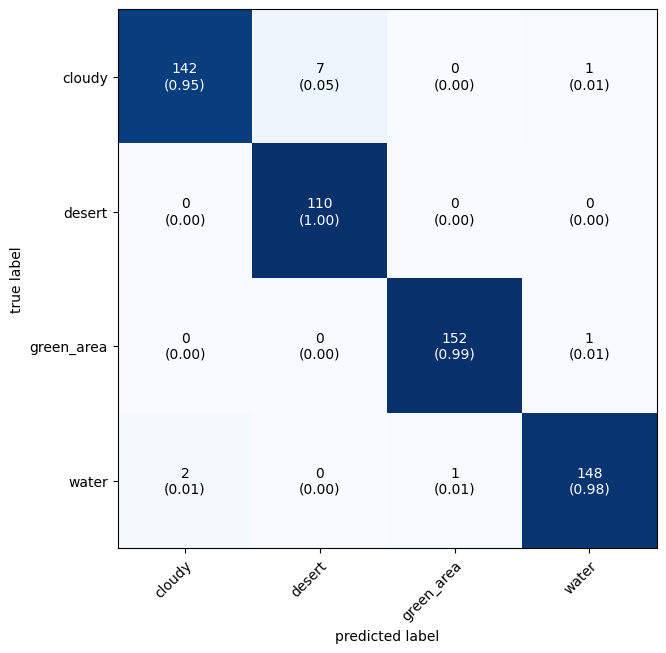

In [71]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm_vgg = confusion_matrix(y_test_,y_pred_vgg_)
plot_confusion_matrix(conf_mat = cm_vgg,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

**ROC AUC CURVE**

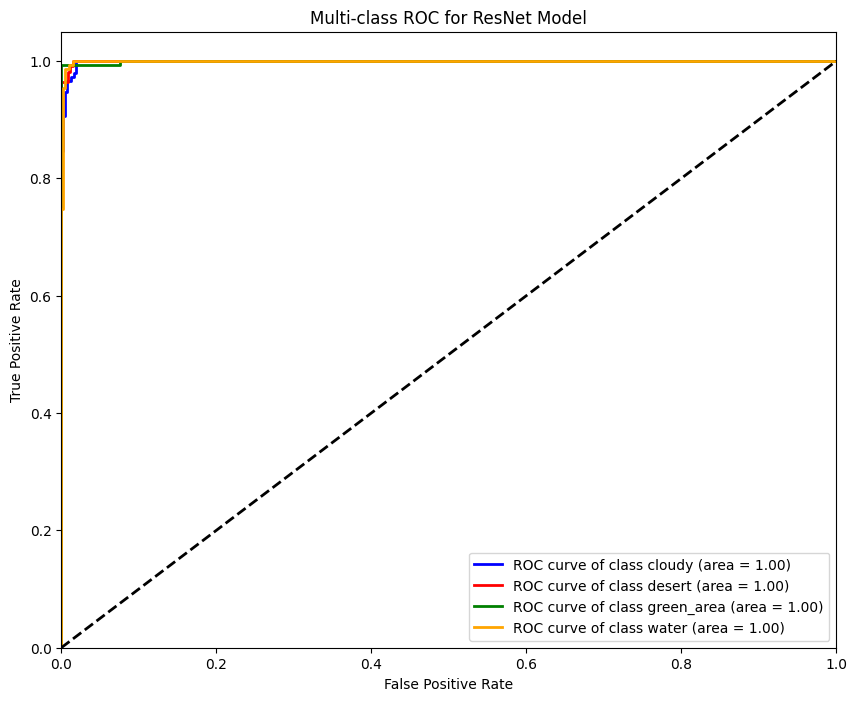

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


# Get class names from your categories
class_names = list(categories.keys())
n_classes = len(class_names)


y_test_bin = label_binarize(y_test_, classes=[0, 1, 2, 3])

# 2. Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):

    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_vgg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange']) # Colors for the 4 classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for ResNet Model')
plt.legend(loc="lower right")
plt.show()

In [73]:
y_test_ = [np.argmax(y) for y in y_test]
y_pred_vgg = vgg_model.predict(X_test)
y_pred_vgg_ = [np.argmax(y) for y in y_pred_vgg]

from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_vgg_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       150
           1       0.94      1.00      0.97       110
           2       0.99      0.99      0.99       153
           3       0.99      0.98      0.98       151

    accuracy                           0.98       564
   macro avg       0.98      0.98      0.98       564
weighted avg       0.98      0.98      0.98       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

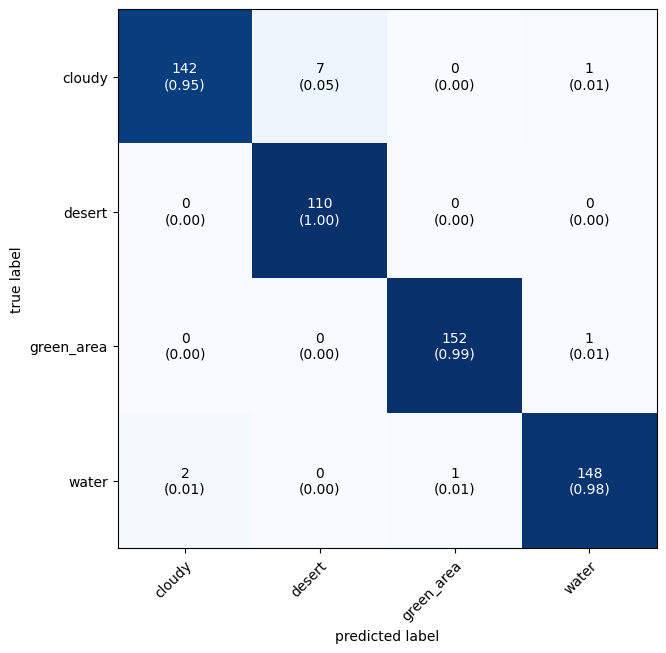

In [74]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm_vgg = confusion_matrix(y_test_,y_pred_vgg_)
plot_confusion_matrix(conf_mat = cm_vgg,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

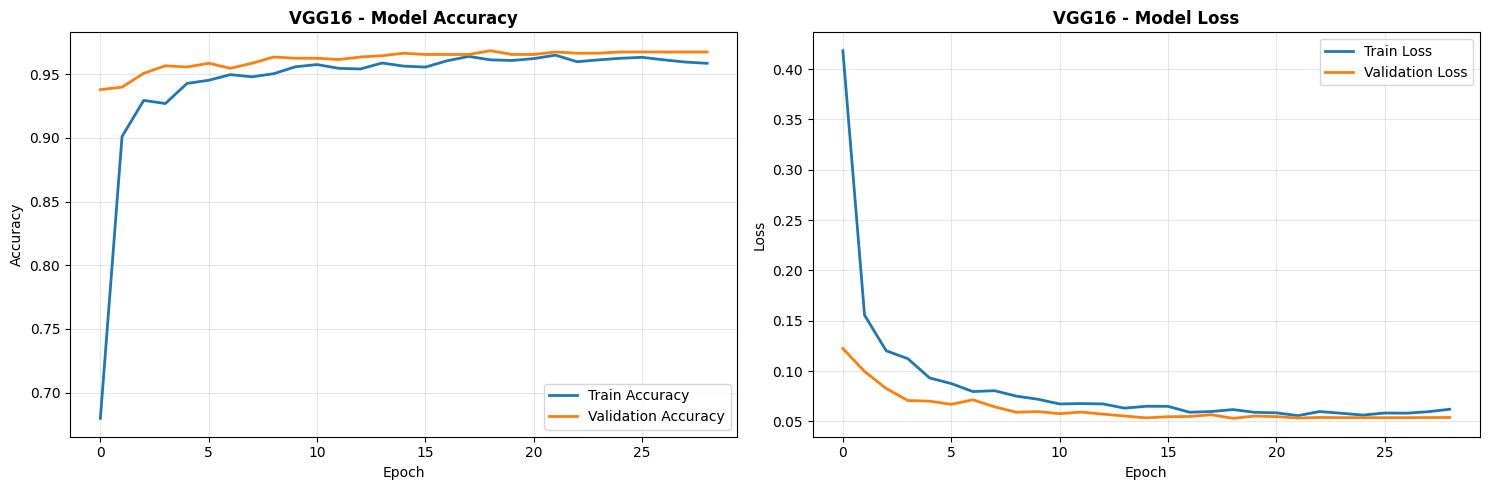


VGG16 PERFORMANCE SUMMARY
Train Accuracy (Final): 0.9585
Val Accuracy (Final):   0.9675
Test Accuracy:          0.9787
Train Loss (Final):     0.0621
Val Loss (Final):       0.0539
Test Loss:              0.0352



In [75]:
# Training and Validation History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_vgg.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_vgg.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('VGG16 - Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history_vgg.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_vgg.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('VGG16 - Model Loss', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test Performance
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*60}")
print("VGG16 PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"Train Accuracy (Final): {history_vgg.history['accuracy'][-1]:.4f}")
print(f"Val Accuracy (Final):   {history_vgg.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy:          {test_acc_vgg:.4f}")
print(f"Train Loss (Final):     {history_vgg.history['loss'][-1]:.4f}")
print(f"Val Loss (Final):       {history_vgg.history['val_loss'][-1]:.4f}")
print(f"Test Loss:              {test_loss_vgg:.4f}")
print(f"{'='*60}\n")

# Store results
all_predictions['VGG16'] = y_pred_vgg
all_metrics.append({
    'model': 'VGG16',
    'test_accuracy': test_acc_vgg,
    'test_loss': test_loss_vgg
})

# Transfer learning with DenseNet201

In [76]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model

def build_densenet_model(input_shape=(128,128,3)):

    base_model = DenseNet201(input_shape=input_shape,include_top=False,weights='imagenet')
    base_model.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(0.4)(model)
    model = Dense(128, activation='relu')(model)
    model = Dense(len(categories),activation='softmax')(model)

    model = Model(inputs = base_model.input, outputs = model)

    return model

densenet_model = build_densenet_model()
densenet_model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 18,568,388 (70.83 MB)

 Trainable params: 246,404 (962.52 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [77]:
densenet_model.compile(optimizer ="adam", loss = "binary_crossentropy",metrics = ['accuracy'])

In [78]:
history_densenet = densenet_model.fit(X_train, y_train,
                    batch_size = 128,
                    epochs = 1000,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks=[model_checkpoint_callback, early_stopping, reducelr])

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.7169 - loss: 0.6366 - val_accuracy: 0.9418 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9386 - loss: 0.1163 - val_accuracy: 0.9606 - val_loss: 0.0689 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9584 - loss: 0.0688 - val_accuracy: 0.9675 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9651 - loss: 0.0545 - val_accuracy: 0.9753 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9699 - loss: 0.0494 - val_accuracy: 0.9724 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9705 - loss: 0.0430 - val_accuracy: 0.9744 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 7/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9708 - loss: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9778 - loss: 0.0360 - val_accuracy: 0.9793 - val_loss: 0.0255 - learning_rate: 9.0000e-05
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9750 - loss: 0.0363 - val_accuracy: 0.9793 - val_loss: 0.0274 - learning_rate: 9.0000e-05
Epoch 14/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9785 - loss: 0.0336
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9784 - loss: 0.0337 - val_accuracy: 0.9793 - val_loss: 0.0246 - learning_rate: 9.0000e-05
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9787 - loss: 0.0324 - val_accuracy: 0.9803 - val_loss: 0.0247 - learning_rate: 2.7000e-05
Epoch 16/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9803 - loss: 0.0291 - val_accuracy: 0.9793 - val_loss: 0.0248 - learning_rate: 2.7000e-05
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9803

### Evaluate DenseNet201 Model

In [79]:
y_pred_densenet = densenet_model.predict(X_test)
y_pred_densenet_ = [np.argmax(y) for y in y_pred_densenet]

from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_densenet_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      1.00      1.00       110
           2       0.99      1.00      1.00       153
           3       0.99      0.98      0.99       151

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

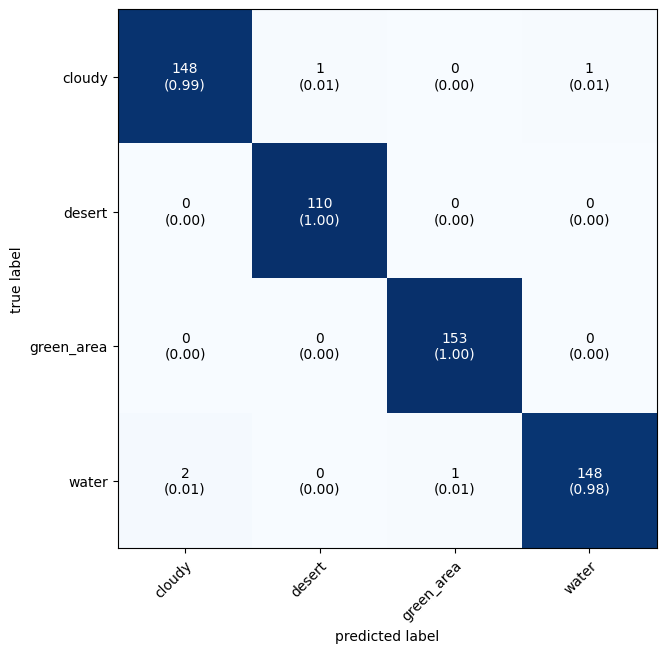

In [80]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm_densenet = confusion_matrix(y_test_,y_pred_densenet_)
plot_confusion_matrix(conf_mat = cm_densenet,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

**ROC AUC CURVE**

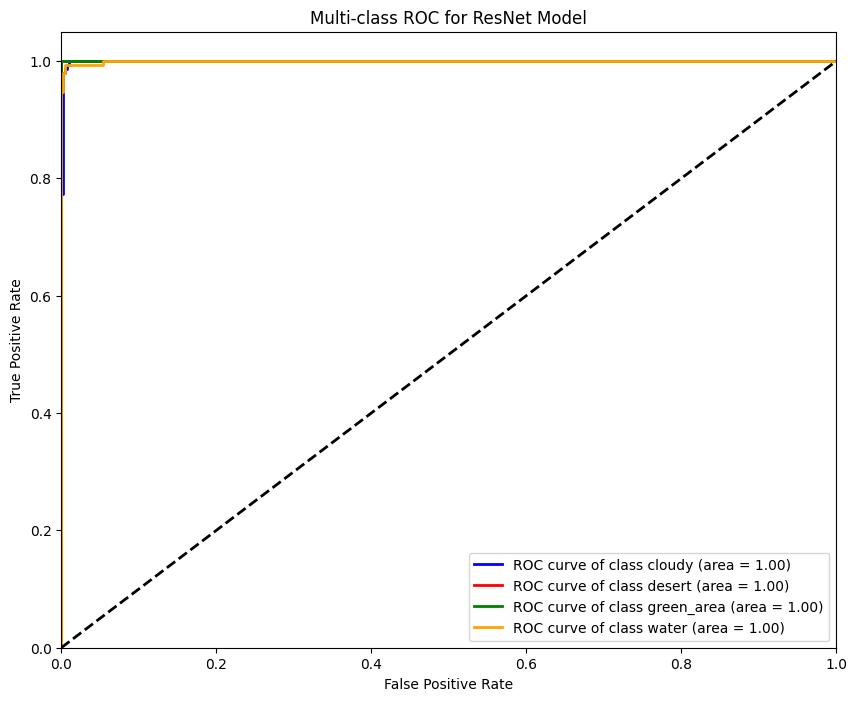

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


# Get class names from your categories
class_names = list(categories.keys())
n_classes = len(class_names)


y_test_bin = label_binarize(y_test_, classes=[0, 1, 2, 3])

# 2. Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):

    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_densenet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange']) # Colors for the 4 classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for ResNet Model')
plt.legend(loc="lower right")
plt.show()

In [82]:
y_pred_densenet = densenet_model.predict(X_test)
y_pred_densenet_ = [np.argmax(y) for y in y_pred_densenet]

from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_densenet_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      1.00      1.00       110
           2       0.99      1.00      1.00       153
           3       0.99      0.98      0.99       151

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

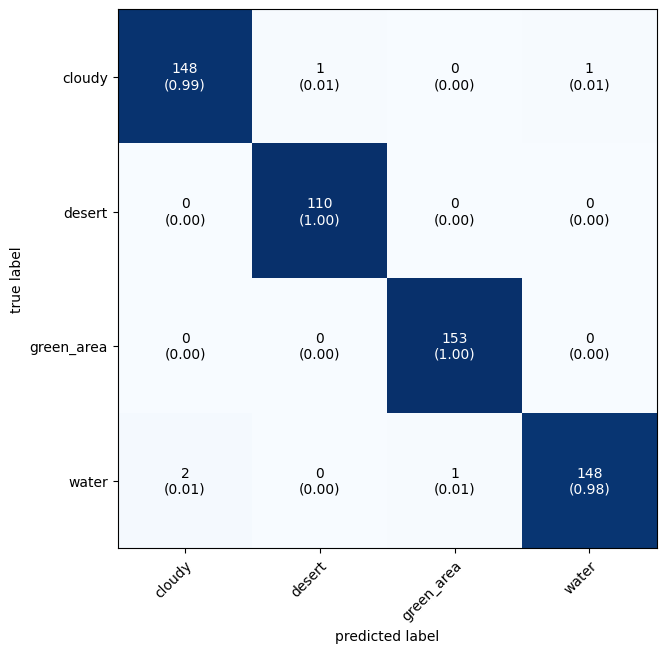

In [83]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm_densenet = confusion_matrix(y_test_,y_pred_densenet_)
plot_confusion_matrix(conf_mat = cm_densenet,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

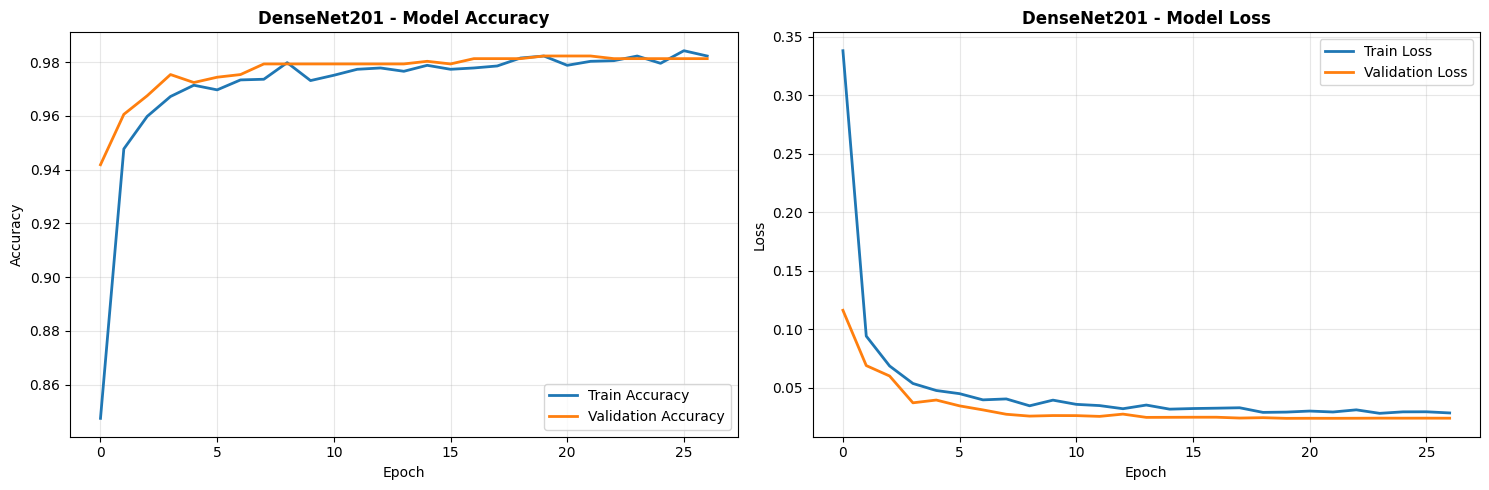


DENSENET201 PERFORMANCE SUMMARY
Train Accuracy (Final): 0.9822
Val Accuracy (Final):   0.9813
Test Accuracy:          0.9911
Train Loss (Final):     0.0284
Val Loss (Final):       0.0239
Test Loss:              0.0151



In [84]:
# Training and Validation History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_densenet.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_densenet.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('DenseNet201 - Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history_densenet.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_densenet.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('DenseNet201 - Model Loss', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test Performance
test_loss_densenet, test_acc_densenet = densenet_model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*60}")
print("DENSENET201 PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"Train Accuracy (Final): {history_densenet.history['accuracy'][-1]:.4f}")
print(f"Val Accuracy (Final):   {history_densenet.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy:          {test_acc_densenet:.4f}")
print(f"Train Loss (Final):     {history_densenet.history['loss'][-1]:.4f}")
print(f"Val Loss (Final):       {history_densenet.history['val_loss'][-1]:.4f}")
print(f"Test Loss:              {test_loss_densenet:.4f}")
print(f"{'='*60}\n")

# Store results
all_predictions['DenseNet201'] = y_pred_densenet
all_metrics.append({
    'model': 'DenseNet201',
    'test_accuracy': test_acc_densenet,
    'test_loss': test_loss_densenet
})

# Transfer learning with ResNet50

In [85]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model

def build_resnet_model(input_shape=(128,128,3)):

    base_model = ResNet50(input_shape=input_shape,include_top=False,weights='imagenet')
    base_model.trainable = False
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(0.4)(model)
    model = Dense(128, activation='relu')(model)
    model = Dense(len(categories),activation='softmax')(model)

    model = Model(inputs = base_model.input, outputs = model)

    return model

resnet_model = build_resnet_model()
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [86]:
resnet_model.compile(optimizer ="adam", loss = "binary_crossentropy",metrics = ['accuracy'])

In [87]:
history_resnet = resnet_model.fit(X_train, y_train,
                    batch_size = 128,
                    epochs = 1000,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks=[model_checkpoint_callback, early_stopping, reducelr])

Epoch 1/1000
 1/32 ━━━━━━━━━━━━━━━━━━━━ 5:52 11s/step - accuracy: 0.2969 - loss: 0.7901

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 618ms/step - accuracy: 0.7564 - loss: 0.3446 - val_accuracy: 0.9734 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9754 - loss: 0.0599 - val_accuracy: 0.9763 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9771 - loss: 0.0431 - val_accuracy: 0.9822 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9874 - loss: 0.0322 - val_accuracy: 0.9852 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9882 - loss: 0.0269 - val_accuracy: 0.9832 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9859 - loss: 0.0263 - val_accuracy: 0.9813 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 7/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9901 - loss: 0.0214
Epoch 

### Evaluate ResNet50 Model

In [88]:
y_pred_resnet = resnet_model.predict(X_test)
y_pred_resnet_ = [np.argmax(y) for y in y_pred_resnet]

from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_resnet_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       1.00      1.00      1.00       110
           2       1.00      1.00      1.00       153
           3       0.99      0.99      0.99       151

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

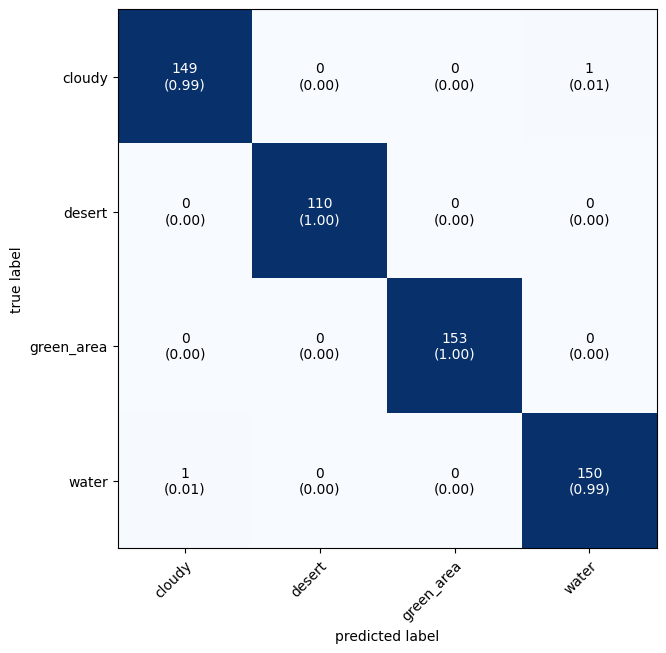

In [89]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm_resnet = confusion_matrix(y_test_,y_pred_resnet_)
plot_confusion_matrix(conf_mat = cm_resnet,figsize=(8,7),class_names =categories.keys(),
                     show_normed = True)

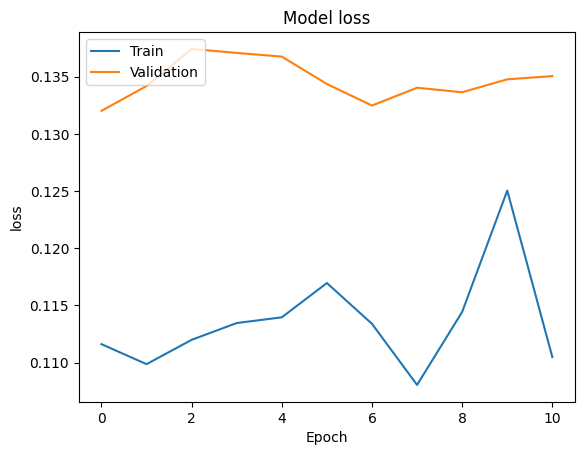

In [90]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

**ROC AUC CURVE RESNET**

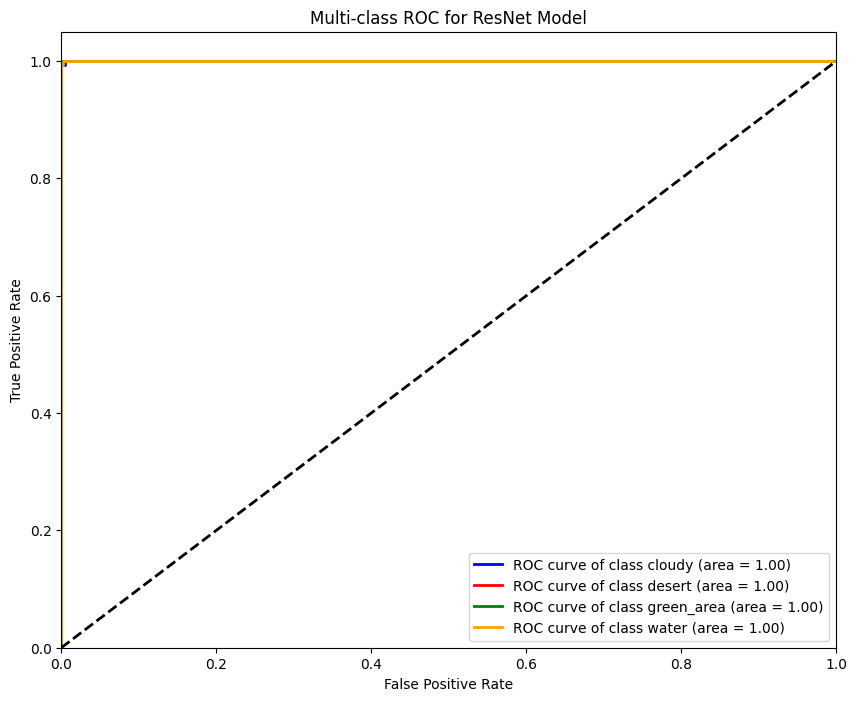

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


# Get class names from your categories
class_names = list(categories.keys())
n_classes = len(class_names)


y_test_bin = label_binarize(y_test_, classes=[0, 1, 2, 3])

# 2. Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):

    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_resnet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange']) # Colors for the 4 classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for ResNet Model')
plt.legend(loc="lower right")
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       150
           1       0.96      0.90      0.93       110
           2       0.73      1.00      0.84       153
           3       1.00      0.62      0.76       151

    accuracy                           0.87       564
   macro avg       0.90      0.87      0.87       564
weighted avg       0.90      0.87      0.87       564



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

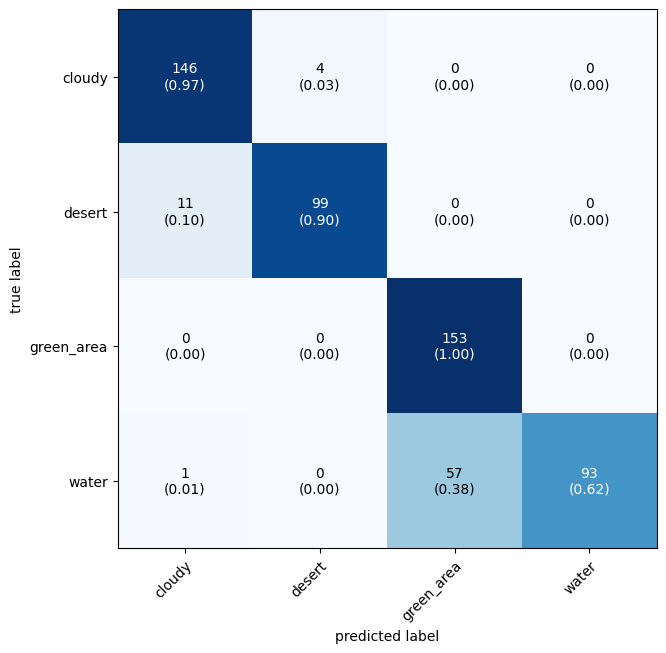

In [92]:
y_pred = model.predict(X_test)
y_pred_ = [np.argmax(y) for y in y_pred]


from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))


from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test_,y_pred_)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names =categories.keys(),show_normed = True)

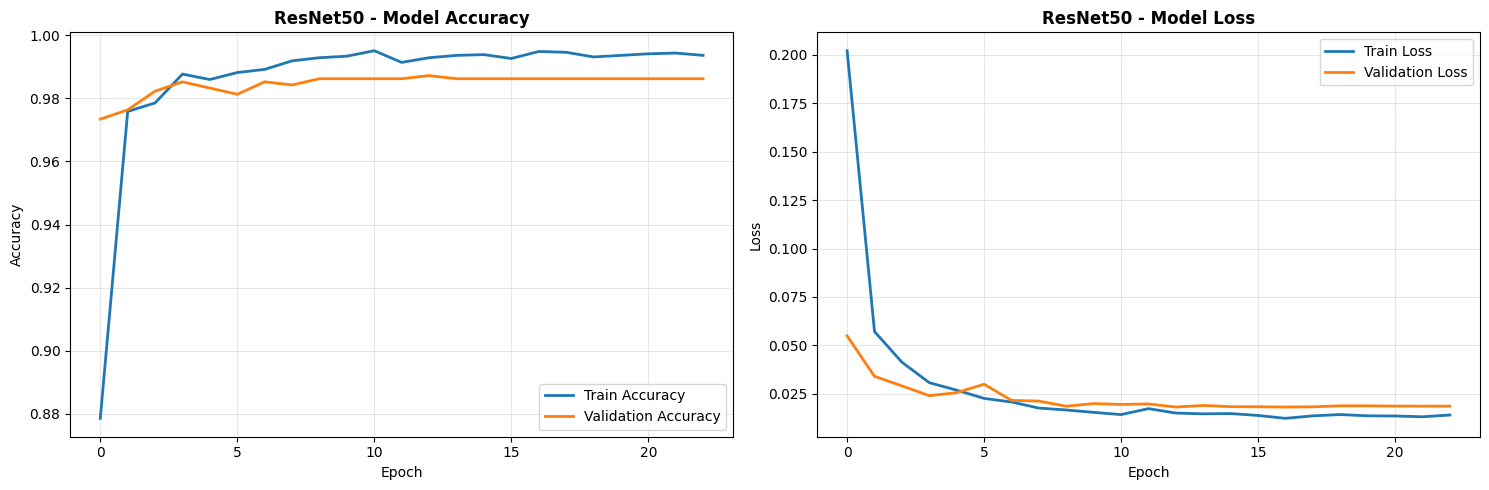


RESNET50 PERFORMANCE SUMMARY
Train Accuracy (Final): 0.9936
Val Accuracy (Final):   0.9862
Test Accuracy:          0.9965
Train Loss (Final):     0.0141
Val Loss (Final):       0.0186
Test Loss:              0.0086



In [93]:
# Training and Validation History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_resnet.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('ResNet50 - Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history_resnet.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_resnet.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('ResNet50 - Model Loss', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test Performance
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*60}")
print("RESNET50 PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"Train Accuracy (Final): {history_resnet.history['accuracy'][-1]:.4f}")
print(f"Val Accuracy (Final):   {history_resnet.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy:          {test_acc_resnet:.4f}")
print(f"Train Loss (Final):     {history_resnet.history['loss'][-1]:.4f}")
print(f"Val Loss (Final):       {history_resnet.history['val_loss'][-1]:.4f}")
print(f"Test Loss:              {test_loss_resnet:.4f}")
print(f"{'='*60}\n")

# Store results
all_predictions['ResNet50'] = y_pred_resnet
all_metrics.append({
    'model': 'ResNet50',
    'test_accuracy': test_acc_resnet,
    'test_loss': test_loss_resnet
})